In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from sklearn.model_selection import GridSearchCV, cross_val_score, LeaveOneOut
from sklearn.metrics import mean_absolute_error
pd.set_option('display.max_columns', 500)

In [25]:
df_gas = pd.read_csv('./aramco/data/CNS_gas_train.csv')

In [26]:
descr = pd.DataFrame(df_gas.iloc[0]).T
df_gas = df_gas.drop(0)
descr

,Country,WELL_NAME,OGA Well Name,WH_SITETYPE,WH_FIELD,WH_BLOCK,WH_LAT,WH_LONG,WH_COORD_SYS,WH_OPERATOR,WH_SPUD_DATE,WH_SPUD_YEAR,WH_COMP_DATE,WH_TD_M,WH_DR_ELEV_M,WH_DEPTH_REF,WH_WATER_DEPTH_M,SAMPLE_ID,SH_DEPTH_TOP_FT,SH_DEPTH_BOT_FT,SH_SAMPLE_TYPE,SH_SAMPLE_SUB_TYPE,SH_ORIG,SH_ORIG_DESC,SH_TREATMENT,SH_TREATMENT_DESC,SH_LITH,SH_AGE,SH_AGE_BOT,SH_FORM,SH_FORM_BOT,SH_CDATE,SH_COMMENT,SAMPLE_ID_GM,SAMPLE_ID_GDB,SAMPLE_ID_SAM,EXT_SAMPLE_VENDOR,SAMPLE_ID_EXT,GAS_METHOD,GAS_LAB,GAS_ACQ_DATE,GAS_TOTAL_CONCENTRATION,GAS_AIR,GAS_C1,GAS_C2,C2_UNSAT,GAS_C3,C3_UNSAT,GAS_IC4,GAS_NC4,C4_UNSAT,GAS_NEOC5,GAS_IC5,GAS_NC5,C5_UNSAT,GAS_NC5_PLUS,GAS_C6PLUS,GAS_O2,GAS_CO2,GAS_H2,GAS_H2S,GAS_HE,GAS_N2,D_G_METHOD,D_G_LAB,D_G_DATA_TYPE,D_G_ACQ_DATE,CSIA_CONC_C1,CSIA_NC1,CSIA_NC2,CSIA_NC3,CSIA_IC4,CSIA_NC4,CSIA_NEOC5,CSIA_IC5,CSIA_NC5,CSIA_ETHENE,CSIA_PROPENE,DC_G_CO2,DO_G_CO2,DS_G_H2S,DD_G_H2,DN_G_N2,DD_G_GAS,DD_G_NC1,DD_G_NC2,DD_G_NC3,DD_G_IC4,DD_G_NC4,DD_G_IC5,DD_G_NC5
0,NaN,Well name,Well name,Site type,Field name,Block name,Latitude,Longitude,Location CRS,Operator,Spud date,Spud year,Completion date,Target depth (m),Derrick floor elevation (m),Depth reference,Water depth (m),Sample code,Top depth in feet,Base depth in feet,Sample type,Sample origin/sub-type,Sample origin,Sample origin description,Sample treatment,Sample treatment description,Sample lithology,Sample age (top),Sample age (bottom),Formation (top),Formation (bottom),Collection date,Sample comments,Sample code GM,Sample code in GDB,Sample code in SAM,Name external data vendor,Sample code external data vendor,Method used,Laboratory,Acquisition date,Total gas concentration (ppm),Air in original sample Mol%,Methane air free Mol%,Ethane air free Mol%,C2 unsaturated air free Mol%,Propane air free Mol%,C3 unsaturated air free Mol%,Iso butane air free Mol%,Normal butane air free Mol%,C4 unsaturated air free Mol%,Neo pentane %,Iso pentane air free Mol%,Normal pentane air free Mol%,C5 unsaturated air free Mol%,C5+ fraction air free Mol%,C6+ fraction air free Mol%,Oxygen,CO2 air free Mol%,Hydrogen air free Mol%,H2S air free Mol%,HE air free Mol%,Nitrogen air free Mol%,Method used,Laboratory,Data type,Acquisition date,vol% C1,dC13 nC1,dC13 nC2,dC13 nC3,dC13 iC4,dC13 nC4,dC13 neopentane,dC13 iC5,dC13 nC5,ethene,propene,dC13 CO2,dO18 CO2,dS34 H2S,dDeuterium on H2,dN15 N2,dDeuterium total GAS,dDeuterium nC1,dDeuterium nC2,dDeuterium nC3,dDeuterium iC4,dDeuterium nC4,dDeuterium iC5,dDeuterium nC5


In [59]:
float_cols = ['WH_LAT', 'WH_LONG', 'WH_SPUD_DATE', 'WH_TD_M',
       'WH_DR_ELEV_M', 'WH_DEPTH_REF', 'WH_WATER_DEPTH_M', 'SAMPLE_ID',
       'SH_DEPTH_BOT_FT', 'SH_TREATMENT_DESC', 'SH_FORM',
       'SH_FORM_BOT', 'GAS_TOTAL_CONCENTRATION',
       'GAS_AIR', 'GAS_C1', 'GAS_C2', 'C2_UNSAT', 'GAS_C3', 'C3_UNSAT',
       'GAS_IC4', 'GAS_NC4', 'C4_UNSAT', 'GAS_NEOC5', 'GAS_IC5', 'GAS_NC5',
       'C5_UNSAT', 'GAS_NC5_PLUS', 'GAS_C6PLUS', 'GAS_O2', 'GAS_CO2', 'GAS_H2',
       'GAS_H2S', 'GAS_HE', 'GAS_N2',
       'CSIA_CONC_C1', 'CSIA_NC1', 'CSIA_NC2', 'CSIA_NC3',
       'CSIA_IC4', 'CSIA_NC4', 'CSIA_NEOC5', 'CSIA_IC5', 'CSIA_NC5',
       'CSIA_ETHENE', 'CSIA_PROPENE', 'DC_G_CO2', 'DO_G_CO2', 'DS_G_H2S',
       'DD_G_H2', 'DN_G_N2', 'DD_G_GAS', 'DD_G_NC1', 'DD_G_NC2', 'DD_G_NC3',
       'DD_G_IC4', 'DD_G_NC4', 'DD_G_IC5', 'DD_G_NC5']
chem_cols = ['GAS_TOTAL_CONCENTRATION',
       'GAS_AIR', 'GAS_C1', 'GAS_C2', 'C2_UNSAT', 'GAS_C3', 'C3_UNSAT',
       'GAS_IC4', 'GAS_NC4', 'C4_UNSAT', 'GAS_NEOC5', 'GAS_IC5', 'GAS_NC5',
       'C5_UNSAT', 'GAS_NC5_PLUS', 'GAS_C6PLUS', 'GAS_O2', 'GAS_CO2', 'GAS_H2',
       'GAS_H2S', 'GAS_HE', 'GAS_N2',
       'CSIA_CONC_C1', 'CSIA_NC1', 'CSIA_NC2', 'CSIA_NC3',
       'CSIA_IC4', 'CSIA_NC4', 'CSIA_NEOC5', 'CSIA_IC5', 'CSIA_NC5',
       'CSIA_ETHENE', 'CSIA_PROPENE', 'DC_G_CO2', 'DO_G_CO2', 'DS_G_H2S',
       'DD_G_H2', 'DN_G_N2', 'DD_G_GAS', 'DD_G_NC1', 'DD_G_NC2', 'DD_G_NC3',
       'DD_G_IC4', 'DD_G_NC4', 'DD_G_IC5', 'DD_G_NC5']
target_cols = ['GAS_C1', 'GAS_C2', 'GAS_C3', 'GAS_IC4', 'GAS_NC4', 'GAS_IC5', 'GAS_NC5']
cat_cols = ['SH_SAMPLE_TYPE', 'SH_SAMPLE_SUB_TYPE', 'SH_ORIG',
            'SH_ORIG_DESC', 'SH_CDATE', 'GAS_METHOD', 'GAS_LAB',
           'D_G_METHOD', 'D_G_LAB']
date_cols = ['WH_SPUD_DATE', 'WH_SPUD_YEAR', 'WH_COMP_DATE', 'D_G_ACQ_DATE']

In [31]:
df = df_gas[chem_cols].astype(float)

In [42]:
df = df[df.columns[df.isnull().mean() < 0.5]]

In [54]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 2

### расмотрим параметры геохимии

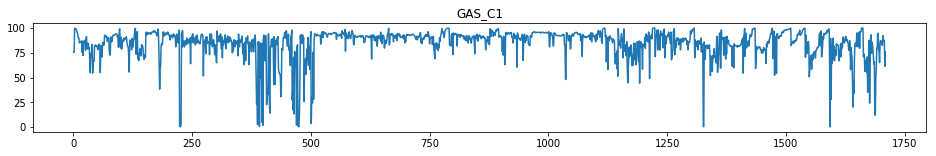

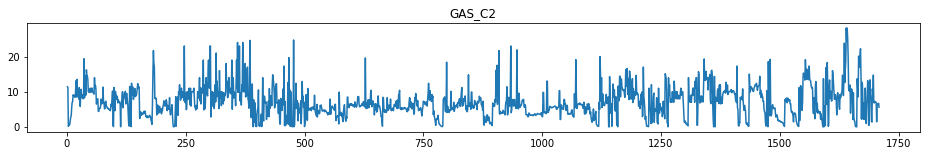

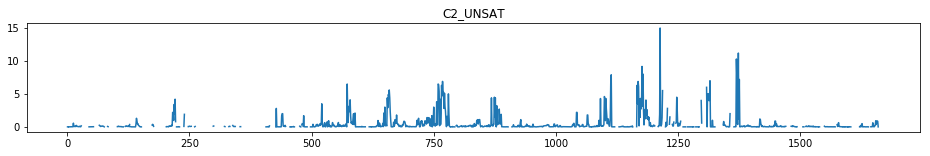

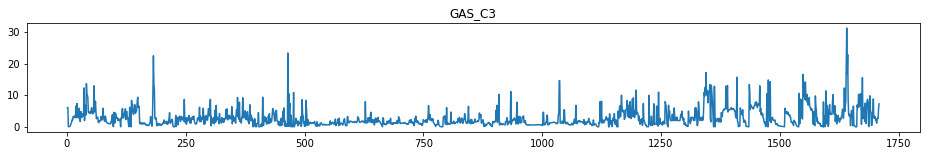

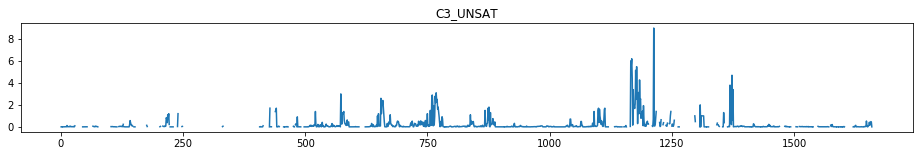

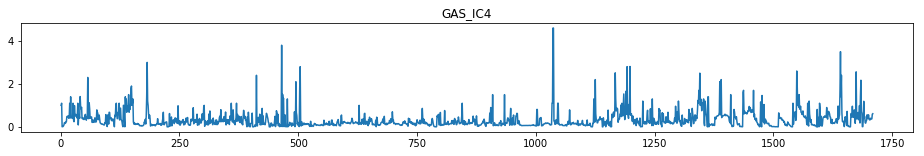

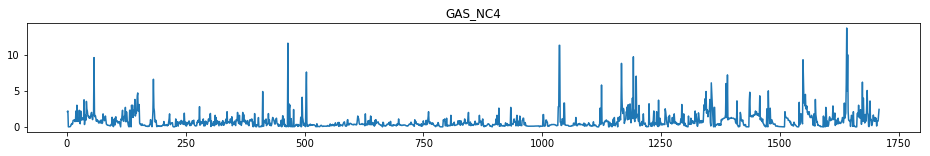

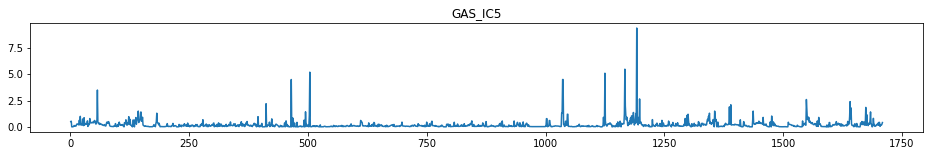

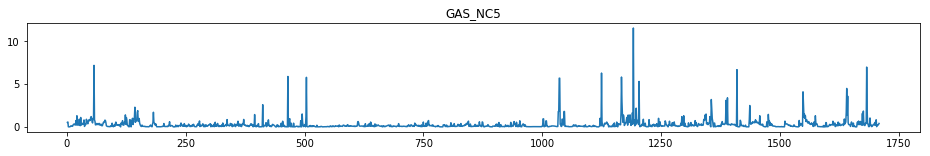

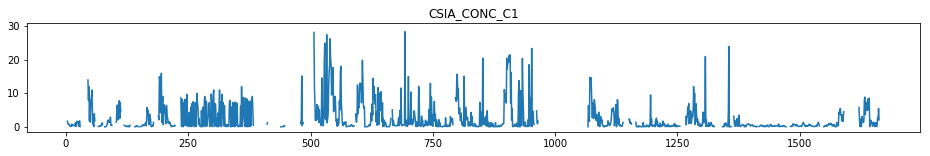

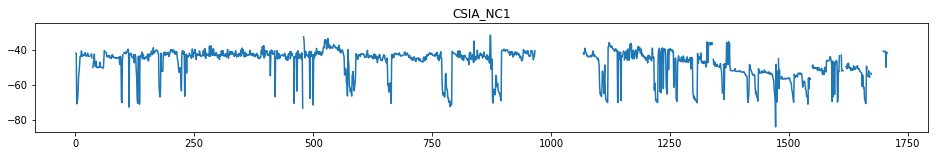

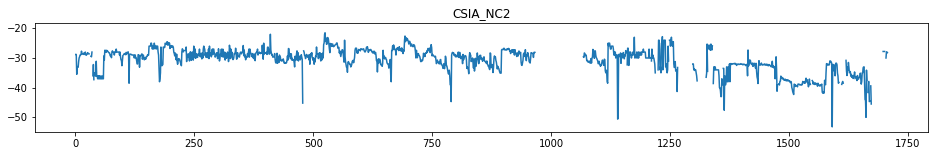

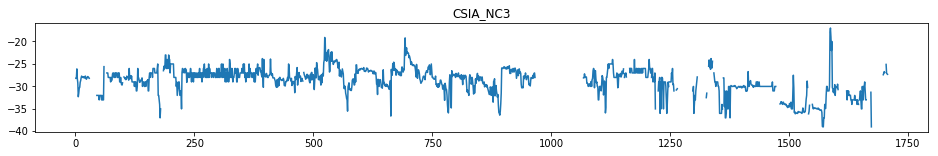

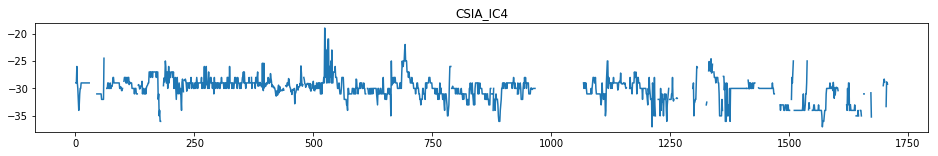

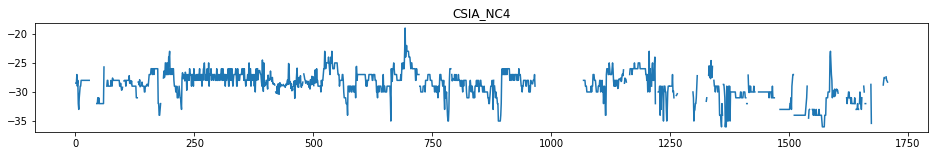

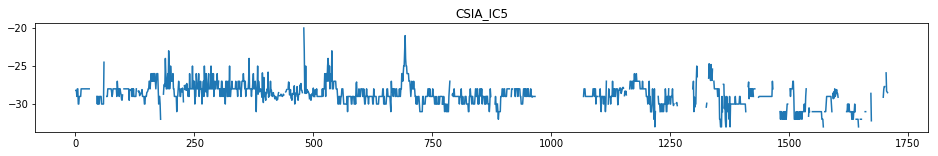

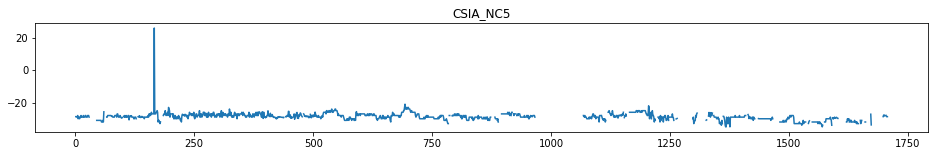

In [55]:
for tag in df.columns:
    plt.figure()
    plt.title(tag)
    df[tag].plot()

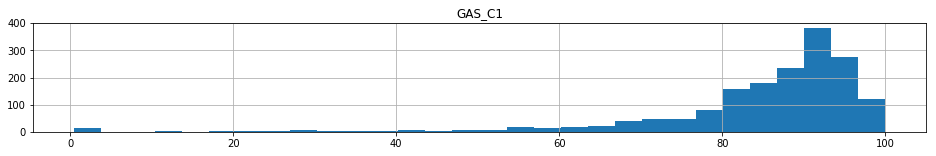

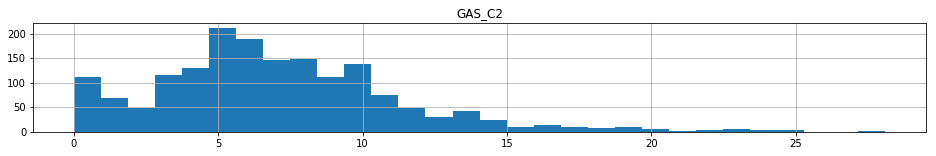

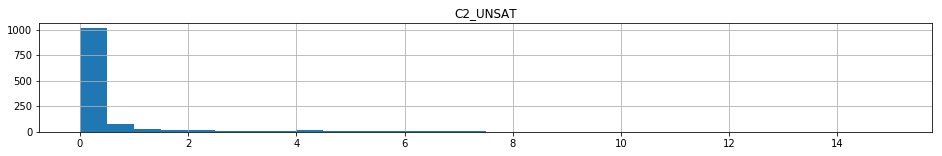

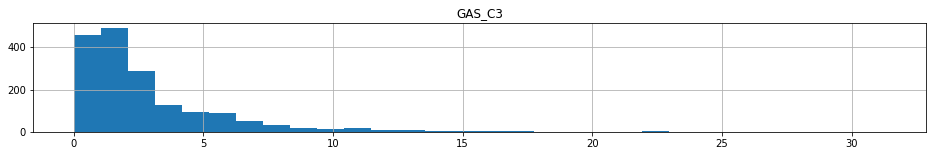

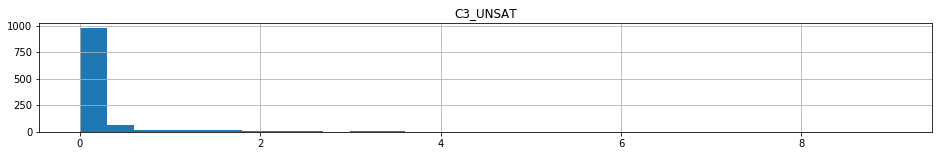

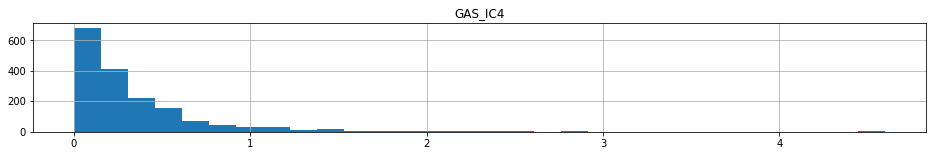

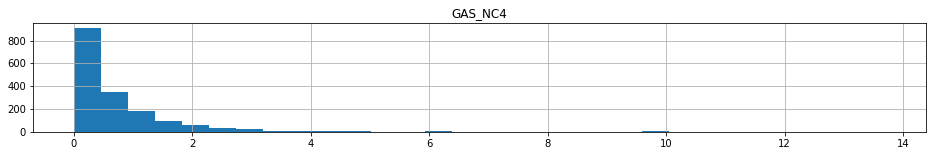

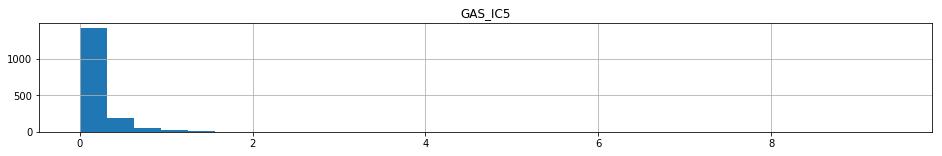

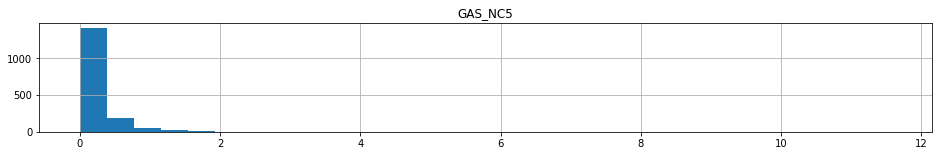

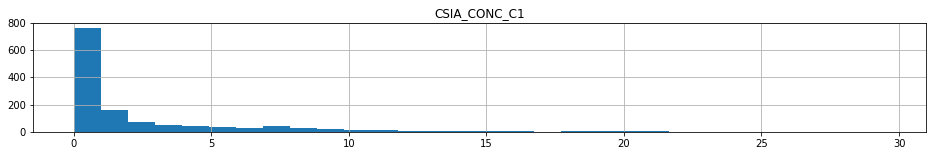

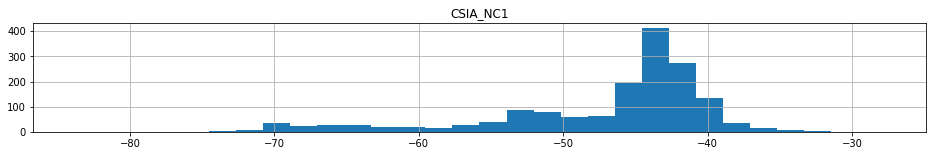

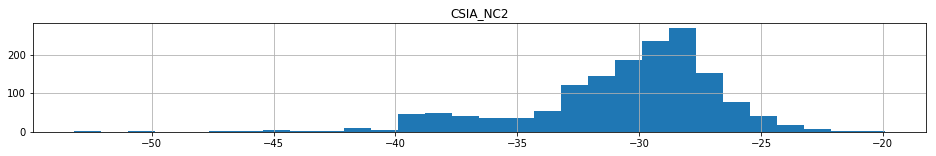

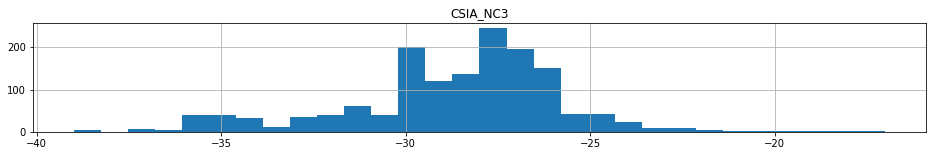

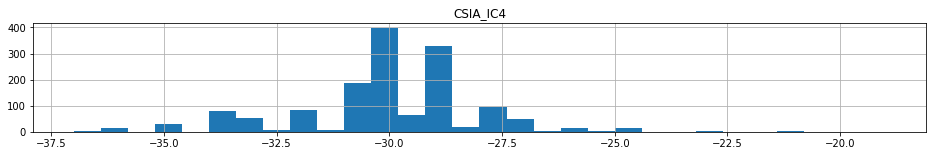

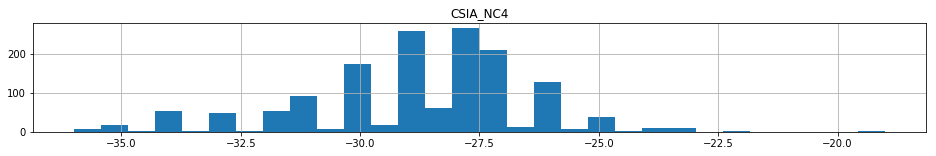

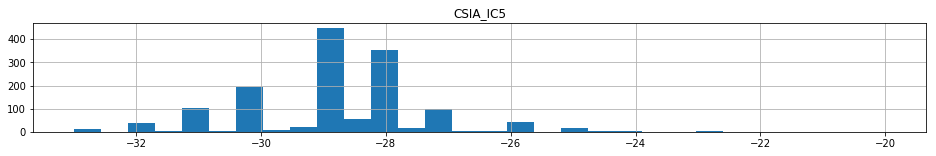

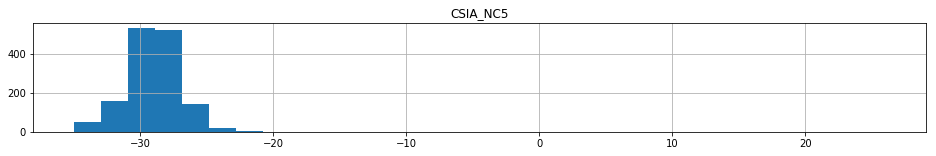

In [58]:
for tag in df.columns:
    plt.figure()
    plt.title(tag)
    df[tag].hist(bins=30)

### для понимания, что такое аномалия, рассмотрим геохимичекие параметры отдельно для каждой скважи

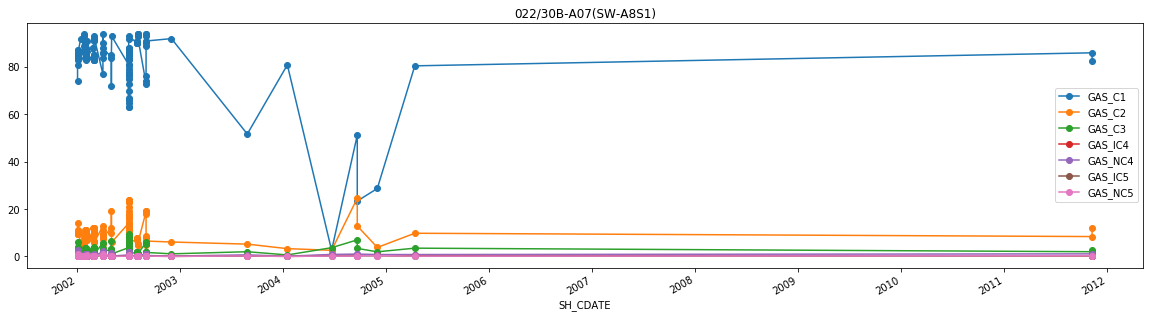

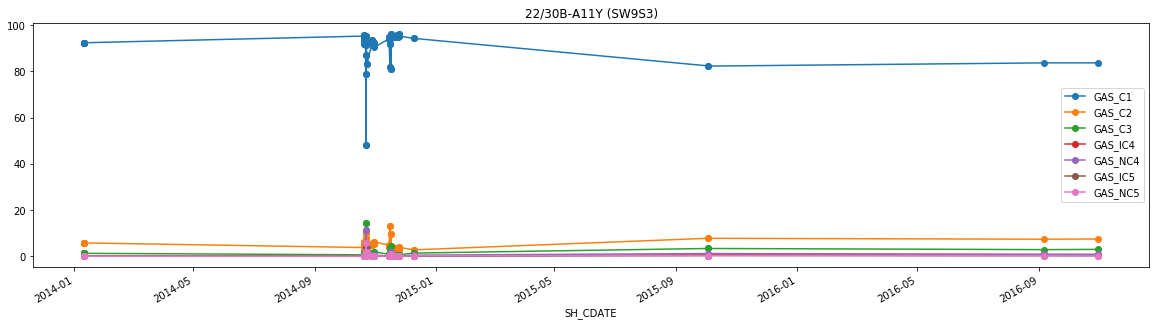

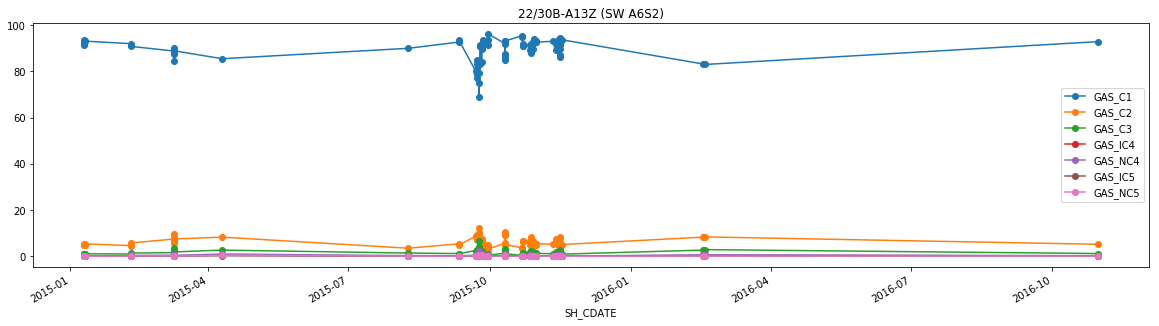

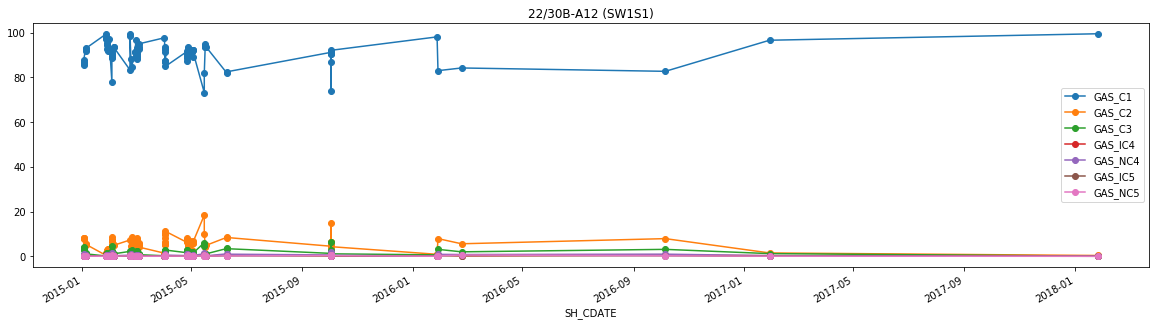

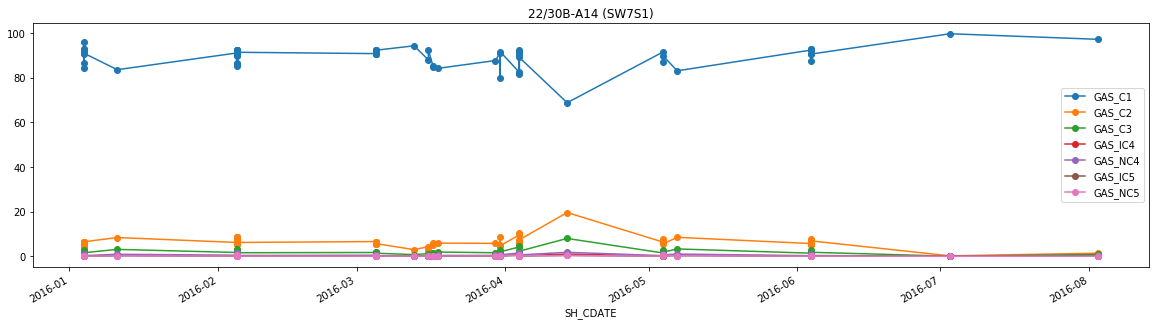

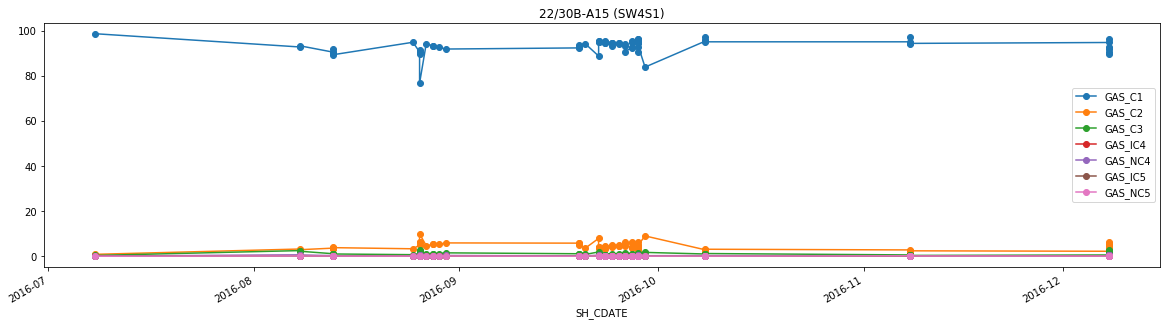

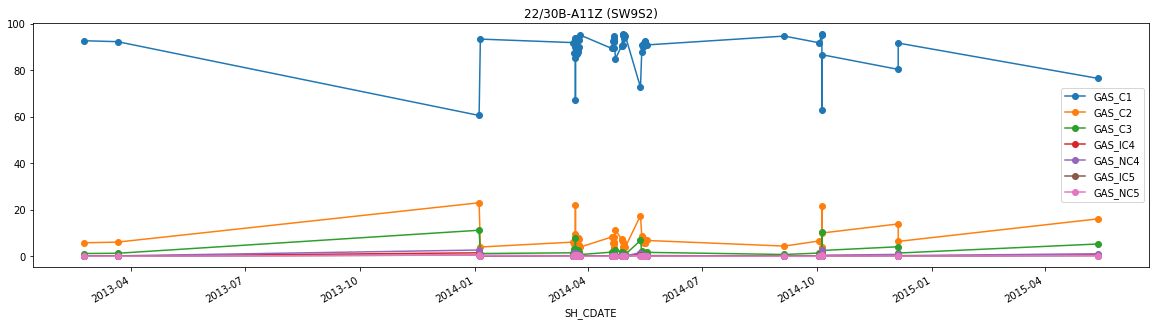

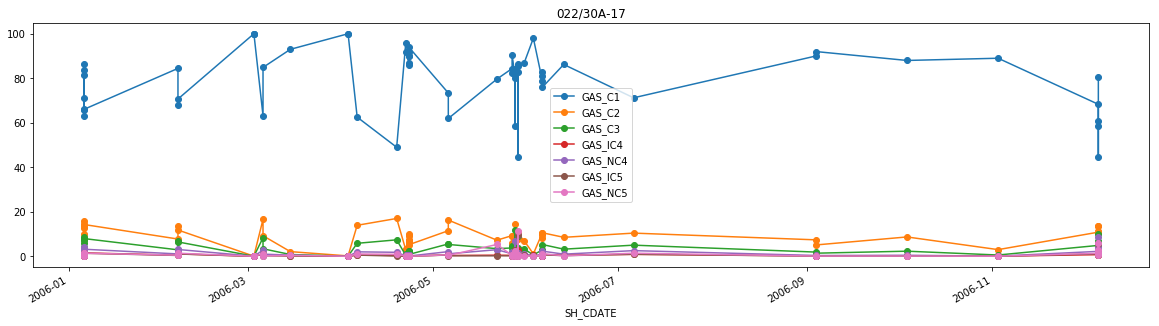

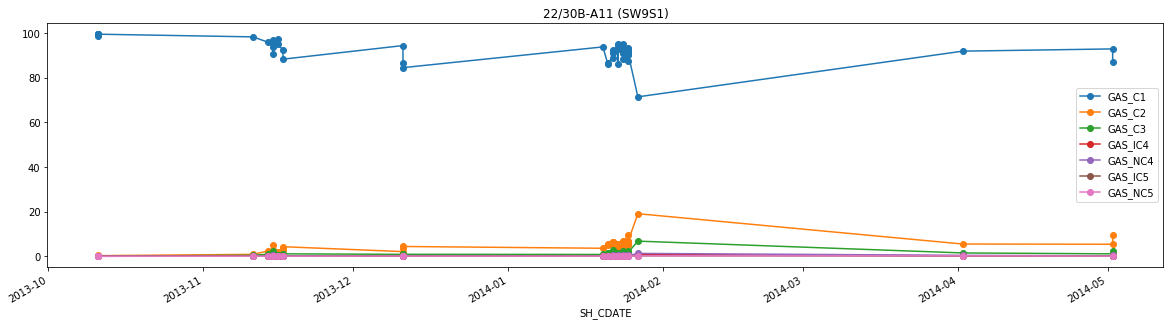

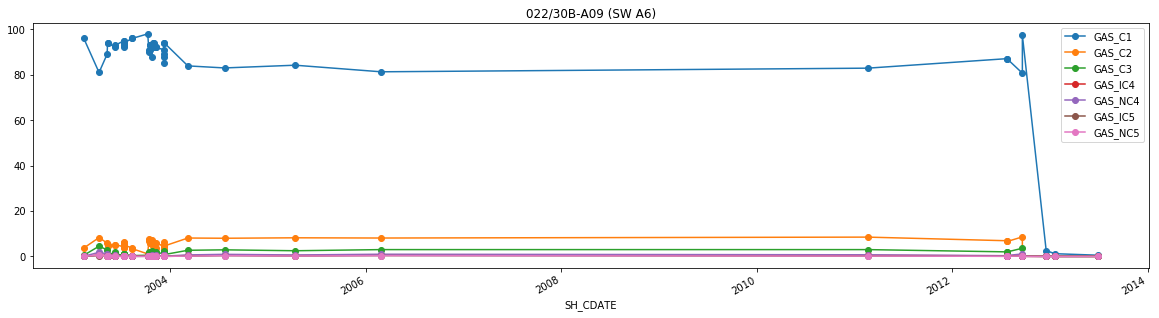

In [66]:
for name in df_gas['WELL_NAME'].value_counts()[:10].index:
    plt.figure(figsize=(20, 5))
    plt.title(name)
    for y in target_cols:
        well = df_gas[df_gas['WELL_NAME'] == name].copy()
        well = well[~well['SH_CDATE'].isnull()]
        well['SH_CDATE'] = pd.to_datetime(well['SH_CDATE'])
        well = well.set_index('SH_CDATE')
        well[y].astype(float).plot(style='-o')
        plt.legend()

### понизим размерность, чтобы в пространстве низкой размерности визуально выделить аномальные пробы газа

In [71]:
from sklearn.decomposition import PCA

In [99]:
pca = PCA(n_components=7)
df_image = pca.fit_transform(df[target_cols])
pca.singular_values_

array([626.27385687, 183.87101803,  65.83170795,  27.01427743,
         9.26661828,   5.93374612,   4.32581691])

In [122]:
pca = PCA(n_components=4)
df_image = pca.fit_transform(df[target_cols])

In [123]:
from mpl_toolkits.mplot3d import Axes3D

In [126]:
import plotly.express as px
fig = px.scatter_3d(pd.DataFrame(data=df_image, columns=['x', 'y', 'z', 'c']),
                    x='x', y='y', z='z', color='c')
fig.show()

In [108]:
from sklearn.manifold import TSNE

In [140]:
tsne = TSNE(n_components=2)
df_tsne = tsne.fit_transform(df[target_cols])

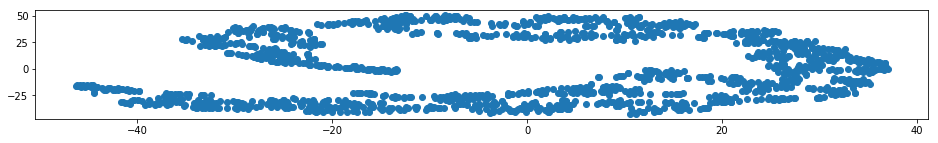

In [141]:
plt.scatter(df_tsne[:, 0], df_tsne[:, 1])
plt.show()

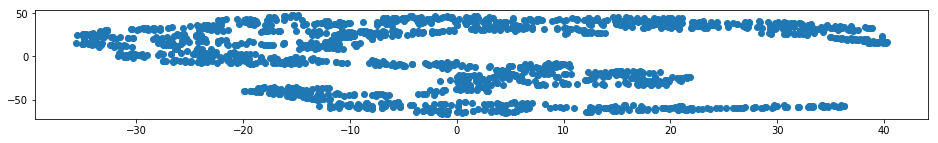

In [128]:
plt.scatter(df_tsne[:, 0], df_tsne[:, 1])
plt.show()